In [186]:
import random
import json
import re
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

random.seed(6)
np.random.seed(6)


# Experiment ? - Llama3.2 3b on chat mode

In this experiment I feed the the model a revisioned version of the input, where the STSG is put the beginning of the prompt and the question with the alternatives at the end. Finally I ask the model to reason about the possible answer *step by step*, conditioning it to perform Zero-Shot-CoT (Prompt engineering technique where no example of thow to perform the reasoning is provided -- no in-context learning). Moreover, instead of asking the model to provide the answer on the same promtp, I instatied the model in multi-turn chat mode where, after the model gives the first response, a script sends an automatic reply asking to extract the final answer given by the model and give it a json format.

**Parameters:**
- model: Gemma3 12b
- system prompt: MCQ_system_promtp_ZS_CoT.txt
- user_prompt: MCQ_user_prompt_ZS_CoT_v2.txt
- temperature: 0.1
- sampling method: (default) top-p (p=0.9)


## Prompts

In [187]:
os.listdir()


['resp_analysis6_deepseek.ipynb',
 'resp_analysis5.ipynb',
 'week_0317_zs_cot_chat_prompting_llama3b.ipynb',
 'week_0317_zs_cot_chat_prompting_gemma3_12b.ipynb',
 'resp_analysis4_ZS.ipynb',
 'resp_analysis6_phi3.ipynb',
 'week_0310_llama8b_as_judgeon_extracted_answers.ipynb',
 'week_0224_llama8b_as_judge.ipynb',
 'blame.txt',
 'resp_analysis6_deepseek7b.ipynb',
 'week_0224_correlation_llama3bvs8b.ipynb',
 'resp_analysis6_llama8b.ipynb',
 'resp_analysis6_llama3b.ipynb',
 'week_0317_zs_cot_chat_prompting_gemma3_4b.ipynb',
 'resp_analysis.ipynb',
 'week_0303_llama8b_as_judge_improving_correlation.ipynb',
 'week_0317_zs_cot_chat_prompting_llama3b copy.ipynb',
 'resp_analysis3.ipynb',
 'week_0234_oneshot_nohtml_tags.ipynb',
 'resp_analysis4_OS.ipynb',
 'resp_analysis2.ipynb',
 'week_0224_llama3b_bias_check.ipynb',
 'week_0303_resp_analysis6_llama8b_regex_extract_last.ipynb',
 'hallucinations_investigation.ipynb']

In [188]:
with open('../data/prompts/zero-shot-cot/MCQ_system_prompt_ZS_CoT.txt', 'r') as f:
    pr = f.read()

print(pr)


You need to respond to reasoning questions by making logical inference on sequence of Scene-Graphs extracted from frames belonging to a video, called a Spatio-Temporal Scene Graph.

IMPORTANT CLARIFICATIONS:
- You will receive a question and Spatio-Temporal Scene-Graph
- Each Scene-Graph is a static symbolic representation of the scene unfolding in the frame
- The Scene-Graphs are ordered chronologically
- The Scene-Graph is represented as a set of tuple in the format: subject - relationship - object
- The Spatio-Temporal Scene-Graph is a cornologically sorted list of Scene-Graphs

INSTRUCTIONS:
- Read the entire Spatio-Temporal Scene-Graphs in chronological order and pay attention at the order of how events unfold.
- Read the question and reason about the answer step by step.
- In your answer include key events or relationships that help you in determing the correct answer.
- Be careful to reproduce the chosen alternative as it is presented.


In [189]:
with open('../data/prompts/zero-shot-cot/MCQ_user_prompt_ZS_CoT_v2.txt', 'r') as f:
    pr = f.read()

print(pr)


Please carefully read the following Spatio-Temporal Scene Graph delimited by the <STSG> tags and provide an answer to the question below:

<STSG>
{stsg}
</STSG>

Given the following question:
<Q>
{question}
<Q>

And the following alternatives:
<Alternatives>
A. {c1}
B. {c2}
C. {c3}
D. {c4}
</Alternatives>

Provide an answer to the above question reasoning step by step on the Spatio-Temporal Scene-Graph (STSG) and choosing one of the alternatives.


In [190]:
reply = """\
Therefore the final answer is?

Your response must be provided in valid JSON format as follows:
{"answer": "your complete answer here"}

IMPORTANT: Always include both the letter (A, B, C, D, etc.) AND the full text of the answer in your response.
Do not abbreviate or shorten the answer. For example, if the correct answer is "A. the laptop", your response 
should be {"answer": "A. the laptop"}, not {"answer": "laptop"} or {"answer": "A"}.\
"""

print(reply)


Therefore the final answer is?

Your response must be provided in valid JSON format as follows:
{"answer": "your complete answer here"}

IMPORTANT: Always include both the letter (A, B, C, D, etc.) AND the full text of the answer in your response.
Do not abbreviate or shorten the answer. For example, if the correct answer is "A. the laptop", your response 
should be {"answer": "A. the laptop"}, not {"answer": "laptop"} or {"answer": "A"}.


Let's load the ground truth from the `STAR_QA_question_and_stsg_val.json` file where we extracted QA and spatio-temporal scene graphs

In [191]:
ground_truth = []

with open('../data/datasets/STAR_QA_and_stsg_val.json') as f:
    data = json.load(f)
    ground_truth = [{
        'id': sample['question_id'],
        'question': sample['question'],
        'choices': sample['choices'],
        'num': sample['answer'],
        'text': sample['choices'][str(sample['answer'])]
    } for sample in data]


# we keep num as str so we can directrly access choices dictionaries
gt_df = pd.DataFrame(ground_truth).astype({'id': 'string', 'num': 'string', 'text': 'string'})
gt_df.set_index('id', inplace=True)
gt_df


,question,choices,num,text
id,,,,
Interaction_T1_13,Which object was tidied up by the person?,"{'0': 'The closet/cabinet.', '1': 'The blanket...",2,The clothes.
Interaction_T1_14,Which object was tidied up by the person?,"{'0': 'The blanket.', '1': 'The table.', '2': ...",2,The clothes.
Interaction_T1_31,Which object was thrown by the person?,"{'0': 'The pillow.', '1': 'The bag.', '2': 'Th...",2,The clothes.
Interaction_T1_32,Which object was put down by the person?,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe.
Interaction_T1_40,Which object was tidied up by the person?,"{'0': 'The broom.', '1': 'The closet/cabinet.'...",1,The closet/cabinet.
...,...,...,...,...
Feasibility_T6_1453,What is the person able to do after taking the...,"{'0': 'Wash the table.', '1': 'Take the box.',...",0,Wash the table.
Feasibility_T6_1454,What is the person able to do after walking th...,"{'0': 'Take the towel.', '1': 'Throw the bag.'...",0,Take the towel.
Feasibility_T6_1455,What is the person able to do after walking th...,"{'0': 'Throw the bag.', '1': 'Wash the table.'...",1,Wash the table.


## Loading predicted answers evaluation

In [192]:
predictions = []
with open('../outputs/responses_gemma3:4b_20250323_20:38:00.jsonl', mode='r', encoding='utf-8', errors='strict') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# transforming the id key from `qid` to `id` for consistency and `response` to `answer`
predictions_df = pd.DataFrame(predictions, dtype='string').rename(columns={'qid':'id', 'response':'answer'})
predictions_df.set_index('id', inplace=True)
predictions_df


,chat_history
id,
Interaction_T1_13,"[{'role': 'user', 'content': ""Please carefully..."
Interaction_T1_14,"[{'role': 'user', 'content': ""Please carefully..."
Interaction_T1_31,"[{'role': 'user', 'content': ""Please carefully..."
Interaction_T1_32,"[{'role': 'user', 'content': ""Please carefully..."
Interaction_T1_40,"[{'role': 'user', 'content': ""Please carefully..."
...,...
Feasibility_T6_1453,"[{'role': 'user', 'content': ""Please carefully..."
Feasibility_T6_1454,"[{'role': 'user', 'content': ""Please carefully..."
Feasibility_T6_1455,"[{'role': 'user', 'content': ""Please carefully..."


In [193]:
predictions_df['chat_history'] = \
    predictions_df['chat_history'] \
    .apply(lambda x: eval(x))

predictions_df


,chat_history
id,
Interaction_T1_13,"[{'role': 'user', 'content': 'Please carefully..."
Interaction_T1_14,"[{'role': 'user', 'content': 'Please carefully..."
Interaction_T1_31,"[{'role': 'user', 'content': 'Please carefully..."
Interaction_T1_32,"[{'role': 'user', 'content': 'Please carefully..."
Interaction_T1_40,"[{'role': 'user', 'content': 'Please carefully..."
...,...
Feasibility_T6_1453,"[{'role': 'user', 'content': 'Please carefully..."
Feasibility_T6_1454,"[{'role': 'user', 'content': 'Please carefully..."
Feasibility_T6_1455,"[{'role': 'user', 'content': 'Please carefully..."


In [194]:
predictions_df['answer'] = predictions_df['chat_history'].apply(lambda x: x[-1]['content'])


In [195]:
predictions_df['answer'].iloc[0:5] 


id
Interaction_T1_13     ```json\n{"answer": "C. The clothes"}\n```
Interaction_T1_14    ```json\n{"answer": "C. The clothes."}\n```
Interaction_T1_31     ```json\n{"answer": "C. The clothes"}\n```
Interaction_T1_32       ```json\n{"answer": "B. The shoe."}\n```
Interaction_T1_40    ```json\n{"answer": "C. The blanket."}\n```
Name: answer, dtype: object

## Text preprocessing

For Gemma we need to be more careful becuase the format is different, it encapsulated the json output in the with the tokens: 
```
```json\n
<actual_answer>
\n```
```

In [196]:

# Create mask for answers that follow JSON syntax
json_mask = predictions_df['answer'].str.match(r'^(```json\s)?({[^}]+})(\s```)?$')
matches_json_template = json_mask.sum()

print(f"Total answers: {len(predictions_df)}")
print(f"Answers following JSON template: {matches_json_template}")
print(f"Percentage following JSON template: {(matches_json_template/len(predictions_df))*100:.2f}%")


Total answers: 7098
Answers following JSON template: 7097
Percentage following JSON template: 99.99%


In [197]:
predictions_df.loc[~json_mask, 'answer']


id
Prediction_T4_1351    ```json\n{"answer": "Therefore the final answe...
Name: answer, dtype: object

In [198]:
predictions_df.loc[json_mask, 'answer'] = \
    predictions_df.loc[json_mask, 'answer'] \
    .apply(lambda x: re.search(r'^(?:```json\s)?({[^}]+})(?:\s```)?$', x).group(1))

predictions_df.loc[~json_mask, 'answer'] = ""
predictions_df['answer']


id
Interaction_T1_13          {"answer": "C. The clothes"}
Interaction_T1_14         {"answer": "C. The clothes."}
Interaction_T1_31          {"answer": "C. The clothes"}
Interaction_T1_32            {"answer": "B. The shoe."}
Interaction_T1_40         {"answer": "C. The blanket."}
                                     ...               
Feasibility_T6_1453    {"answer": "A. Wash the table."}
Feasibility_T6_1454     {"answer": "A. Take the towel"}
Feasibility_T6_1455    {"answer": "B. Wash the table."}
Feasibility_T6_1456    {"answer": "D. Wash the table."}
Feasibility_T6_1468      {"answer": "B. Hold the food"}
Name: answer, Length: 7098, dtype: object

### The need to replace single quotes

In [199]:
print('\u2018'), print('\u2019'), print('\u201a'), print('\u201b'), print('\u201c'), print('\u201d')


‘
’
‚
‛
“
”


(None, None, None, None, None, None)

In [200]:
el = predictions_df.loc['Interaction_T3_3111']
el


chat_history    [{'role': 'user', 'content': 'Please carefully...
answer          {"answer": "None of the above - The scene grap...
Name: Interaction_T3_3111, dtype: object

In [201]:
re.findall('[\u2018-\u201b]', el['answer'])


['’', '‘', '’']

In [202]:
re.findall('[\u201c-\u201d]', el['answer'])


['”']

In [203]:
import unicodedata

def print_unicode_codes(s):
    print("Char | Unicode Point | UTF-8 Bytes | Name")
    print("-" * 50)
    for char in s:
        code = ord(char)
        utf8_bytes = list(char.encode('utf-8'))
        try:
            name = unicodedata.name(char)
        except ValueError:
            name = "No name"
        print(f"'{char}'  | U+{code:04X}       | {utf8_bytes}      | {name}")

# Requires: import unicodedata
print_unicode_codes(el['answer'])


Char | Unicode Point | UTF-8 Bytes | Name
--------------------------------------------------
'{'  | U+007B       | [123]      | LEFT CURLY BRACKET
'"'  | U+0022       | [34]      | QUOTATION MARK
'a'  | U+0061       | [97]      | LATIN SMALL LETTER A
'n'  | U+006E       | [110]      | LATIN SMALL LETTER N
's'  | U+0073       | [115]      | LATIN SMALL LETTER S
'w'  | U+0077       | [119]      | LATIN SMALL LETTER W
'e'  | U+0065       | [101]      | LATIN SMALL LETTER E
'r'  | U+0072       | [114]      | LATIN SMALL LETTER R
'"'  | U+0022       | [34]      | QUOTATION MARK
':'  | U+003A       | [58]      | COLON
' '  | U+0020       | [32]      | SPACE
'"'  | U+0022       | [34]      | QUOTATION MARK
'N'  | U+004E       | [78]      | LATIN CAPITAL LETTER N
'o'  | U+006F       | [111]      | LATIN SMALL LETTER O
'n'  | U+006E       | [110]      | LATIN SMALL LETTER N
'e'  | U+0065       | [101]      | LATIN SMALL LETTER E
' '  | U+0020       | [32]      | SPACE
'o'  | U+006F       | [111

In [204]:
import tokenize
from io import StringIO
import ast

def debug_parsing(code):
    try:
        # First try full parse
        ast.parse(code)
    except SyntaxError as e:
        print(f"Full parse failed at line {e.lineno}")
        print("Token stream up to error:")
        
        # Show token stream
        tokens = tokenize.generate_tokens(StringIO(code).readline)
        for tok in tokens:
            print(f"{tokenize.tok_name[tok.type]:<15} {tok.string!r:<20} {tok.start}->{tok.end}")
            if tok.start[0] > e.lineno or (
                tok.start[0] == e.lineno and tok.start[1] >= e.offset
            ):
                print("-- Error occurs here --")
                break

debug_parsing(el['answer'])


Full parse failed at line 1
Token stream up to error:
OP              '{'                  (1, 0)->(1, 1)
STRING          '"answer"'           (1, 1)->(1, 9)
OP              ':'                  (1, 9)->(1, 10)
ERRORTOKEN      ' '                  (1, 10)->(1, 11)
ERRORTOKEN      '"'                  (1, 11)->(1, 12)
NAME            'None'               (1, 12)->(1, 16)
NAME            'of'                 (1, 17)->(1, 19)
NAME            'the'                (1, 20)->(1, 23)
NAME            'above'              (1, 24)->(1, 29)
OP              '-'                  (1, 30)->(1, 31)
NAME            'The'                (1, 32)->(1, 35)
NAME            'scene'              (1, 36)->(1, 41)
NAME            'graph'              (1, 42)->(1, 47)
NAME            'doesn'              (1, 48)->(1, 53)
ERRORTOKEN      '’'                  (1, 53)->(1, 54)
NAME            't'                  (1, 54)->(1, 55)
NAME            'provide'            (1, 56)->(1, 63)
NAME            'a'              

### Applying changes

In [205]:
# Replace new line (lead to EOF Errors) with whitespace
predictions_df['answer'] = \
    predictions_df['answer'].str.replace('\n+', ' ', regex=True)

# Replace lef and right quotation mark with simple quotation mark
predictions_df['answer'] = \
    predictions_df['answer'].str.replace('[\u2018-\u201b]', '\'', regex=True)
predictions_df['answer'] = \
    predictions_df['answer'].str.replace('[\u201c\u201d]', '"', regex=True)
# ------------------ Removing inner double quotes --------------------
# It may happen that the text may contain inner double quotes before the
# attribute end. This will cause the parser to termiate early and spout
# errors for the remaining text. With this snippet we replace those inner
# double quotes with single quotes.
#  
# we first match the text of the reason paramter inside the double quotes
# then we escape/replace all the double quotes inside the text
inside_doublequotes = r"(?<=\"answer\": \")(.*)(?=\"(?:,|}))"

predictions_df['answer'] = \
    predictions_df.apply(
        func=lambda row: re.sub(
            inside_doublequotes, 
            lambda matchobj: matchobj.group(0).replace('\"', ''), 
            row['answer']),
        axis=1
        )


In [206]:
predictions_df.loc[json_mask, 'answer'] = predictions_df.loc[json_mask, 'answer'].apply(lambda x: eval(x)['answer'].strip())
predictions_df


,chat_history,answer
id,,
Interaction_T1_13,"[{'role': 'user', 'content': 'Please carefully...",C. The clothes
Interaction_T1_14,"[{'role': 'user', 'content': 'Please carefully...",C. The clothes.
Interaction_T1_31,"[{'role': 'user', 'content': 'Please carefully...",C. The clothes
Interaction_T1_32,"[{'role': 'user', 'content': 'Please carefully...",B. The shoe.
Interaction_T1_40,"[{'role': 'user', 'content': 'Please carefully...",C. The blanket.
...,...,...
Feasibility_T6_1453,"[{'role': 'user', 'content': 'Please carefully...",A. Wash the table.
Feasibility_T6_1454,"[{'role': 'user', 'content': 'Please carefully...",A. Take the towel
Feasibility_T6_1455,"[{'role': 'user', 'content': 'Please carefully...",B. Wash the table.


In [207]:
ans_regex_pattern = r'^(?:[A-Z]\.)\s+((?:\w+(?:\s|\/)?){,10}\.?)'
contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, regex=True)

print(f"Answer following the template: {contains_answer.value_counts()[True]}\n"
      f"{contains_answer.value_counts()[True]/predictions_df.shape[0]:.2%} of the total")

print(f"\nOnly {contains_answer.value_counts()[False]} samples do not contain the answer in the response with the specified format")


Answer following the template: 6778
95.49% of the total

Only 320 samples do not contain the answer in the response with the specified format


/tmp/ipykernel_168044/3127831504.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, regex=True)


In [208]:
predictions_df.loc[~contains_answer, 'answer']


id
Interaction_T1_198     None of the alternatives are correct based on ...
Interaction_T1_1255                None of the alternatives are correct.
Interaction_T1_1369                None of the alternatives are correct.
Interaction_T1_1671    None of the alternatives can be determined fro...
Interaction_T1_2509    None of the alternatives are correct based on ...
                                             ...                        
Feasibility_T6_448                                     None of the above
Feasibility_T6_1063    None of the alternatives are correct. The grap...
Feasibility_T6_1091    None of the alternatives are correct based on ...
Feasibility_T6_1153    None of the alternatives are correct based on ...
Feasibility_T6_1344    None of the provided alternatives accurately d...
Name: answer, Length: 320, dtype: object

## Extract answers

In [209]:
ans_df = \
    predictions_df[contains_answer]['answer'] \
    .apply(lambda x: re.findall(ans_regex_pattern, x)[-1]) \
    .apply(lambda x: x + '.' if not x.endswith('.') else x) \
    .to_frame(name='text')

ans_df.rename(columns={0: 'text'}, inplace=True)

ans_df['text'] = ans_df['text'].str.strip()
ans_df


,text
id,
Interaction_T1_13,The clothes.
Interaction_T1_14,The clothes.
Interaction_T1_31,The clothes.
Interaction_T1_32,The shoe.
Interaction_T1_40,The blanket.
...,...
Feasibility_T6_1453,Wash the table.
Feasibility_T6_1454,Take the towel.
Feasibility_T6_1455,Wash the table.


In [210]:
ans_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6778 entries, Interaction_T1_13 to Feasibility_T6_1468
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6778 non-null   object
dtypes: object(1)
memory usage: 105.9+ KB


In [211]:
freq = ans_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

print(f"We have {freq.size} unique answers")


We have 476 unique answers


In [212]:
ans_df['text'].value_counts()


Took.                 569
Put down.             321
Opened.               217
The book.             195
The towel.            186
                     ... 
Washed the window.      1
Wash the mirror.        1
Close.                  1
the broom.              1
Throw the food.         1
Name: text, Length: 238, dtype: int64

<AxesSubplot: xlabel='freq', ylabel='word'>

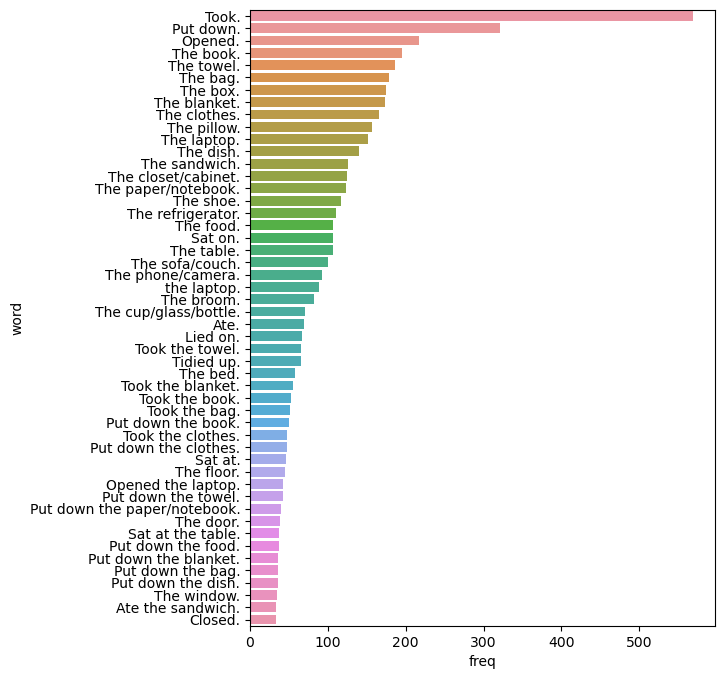

In [213]:
plt.figure(figsize=(6, 8))
sns.barplot(data=freq.sort_values('freq', ascending=False)[:50], x='freq', y='word')


Let's do some visualization also for the ground truth data

In [214]:
print(f"We have {gt_df['text'].nunique()} unique answers")


We have 198 unique answers


<AxesSubplot: xlabel='freq', ylabel='word'>

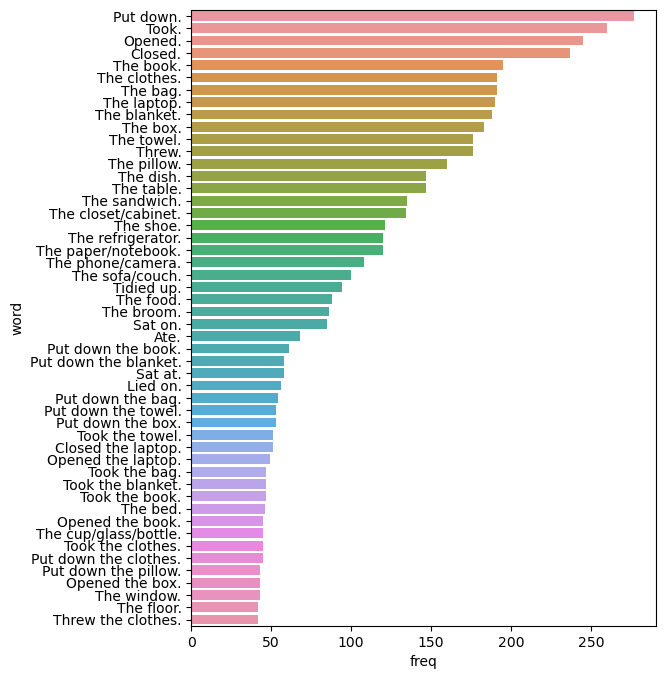

In [215]:
freq = gt_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

plt.figure(figsize=(6, 8))
sns.barplot(data=freq.sort_values('freq', ascending=False)[:50], x='freq', y='word')


In [216]:
# Inner join - keeps only indices present in both series

ans_df.rename(columns={'text': 'pred_text'}, inplace=True)
eval_df = gt_df.join(
    ans_df, 
    how='inner' # we account also for samples without answers
)

eval_df.shape


(6778, 5)

In [217]:
def accuracy(eval_df, on_what='text'):
    hits_text = (eval_df[f'pred_{on_what}'].str.lower() == eval_df[on_what].str.lower()).sum()
    

    return hits_text/eval_df.shape[0]


check if the equality with NA result in a false or is skipped

In [218]:
real_acc = accuracy(eval_df) * eval_df.shape[0] / gt_df.shape[0]

print(f"Real Accuracy: {real_acc:.2%}")


Real Accuracy: 62.79%


In [219]:
def print_acc(eval_df, acc_fn):
    print(f"{'Question type':<15}{'Total':^15}{'Accuracy':^10}\n")

    total = eval_df.index.str.startswith('Interaction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Interaction')])
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Sequence').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Sequence')])
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Prediction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Prediction')])
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Feasibility').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Feasibility')])
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")


In [220]:
print_acc(eval_df, lambda x: accuracy(x, on_what='text'))


Question type       Total      Accuracy 

Interaction         2288        60.80%  
Sequence            3397        66.82%  
Prediction           615        76.75%  
Feasibility          478        67.78%  


In [221]:
# % of answers conforming to template per category

def print_ans_perc(eval_df, gt_df):
    print(f"{'Question type':<15}{'Total':^15}{'Answered':^10}\n")

    total = gt_df.index.str.startswith('Interaction').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Interaction')].index))/total
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Sequence').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Sequence')].index))/total
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Prediction').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Prediction')].index))/total
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Feasibility').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Feasibility')].index))/total
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.shape[0]
    acc = eval_df.shape[0]/total
    print(f"{'Overall':<15}{total:^15}{acc:^10.2%}")

print_ans_perc(eval_df, gt_df)


Question type       Total      Answered 

Interaction         2398        95.41%  
Sequence            3586        94.73%  
Prediction           624        98.56%  
Feasibility          490        97.55%  
Overall             7098        95.49%  
